# Support Vector Machine with Natural Language Processing:

**Support Vector Machines (SVMs)** can be used in combination with Natural Language Processing (NLP) for email spam classification. SVMs are powerful machine learning algorithms commonly used for binary classification tasks, and they can work well with text data when combined with appropriate NLP techniques.

**GridSearch**, a hyperparameter tuning technique, is used to systematically search for the best combination of hyperparameters for a machine learning model. It involves specifying a range of values for each hyperparameter and then exhaustively evaluating all possible combinations through cross-validation. This helps identify the hyperparameter configuration that yields the optimal model performance on a validation dataset.

### Importing Libraries & Dataset:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string # Working with string operations
import re # Regular expression operations
import spacy # Natural language processing tasks
import nltk # Natural language processing functionalities
from spacy.lang.en.examples import sentences  # Import example sentences from English language model
from nltk.corpus import stopwords  # Import stopwords from NLTK
from sklearn.model_selection import train_test_split  # Import train-test split function
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Import text vectorization techniques
from sklearn.svm import LinearSVC  # Import Linear Support Vector Classifier
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV for hyperparameter tuning
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report  # Import various evaluation metrics
from sklearn.svm import SVC  # Import Support Vector Classifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Preprocessing:

In [2]:
df.shape

(5572, 2)

In [3]:
# Check for Duplicates:
df.duplicated().sum()

415

In [4]:
# Remove the Duplicates:
df.drop_duplicates(inplace = True)
df.shape # Duplicates are dropped now.

(5157, 2)

In [5]:
df['Category'] = df['Category'].apply(lambda x:1 if x == 'spam' else 0)

# Column that only has words & space.
words = []
for i in df['Message']:
    i = i.lower()
    i = re.sub("[^a-z0-9 ]", '', i)
# Removing everything except space & a-z.
    words.append(i)

df['Words'] = words
df.head()

,Category,Message,Words
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [6]:
# We load SpaCy's English statistical model to enable NLP tasks for 
# an English corpus.
nlp = spacy.load('en_core_web_sm')
stopWords = set(stopwords.words('english')) # Save stopwords as a set
punctuations = string.punctuation # List of punctuation marks

In [7]:
def message_cleaner(sentence):
    """
    Function message_cleaner cleans the text using typical Natural Language Processing
    (NLP) steps. 
    Steps include: Lemmatization, removing stop words, removing punctuations  
    Args:
        sentence (str): The uncleaned text. 
    Returns:
        str: The cleaned text.
    """
    # Create the Doc object named `text` from `sentence` using `nlp()`
    text = nlp(sentence)    
    # Lemmatization - remove the lemmas -PRON-     
    text = [token.lemma_ for token in text if token.lemma_ != "-PRON-"]
    # Remove stop words
    text = [token for token in text if token not in stopWords]
    # Remove punctuations
    text = [token for token in text if token not in punctuations]
    # Use the .join() method on text to convert string
    text = " ".join(text)
    # Use re.sub() to substitute multiple spaces or dots`[\.\s]+` to single space `' '`
    text  = re.sub('[\.\s]+', ' ', text)
    # Return the cleaned text
    return text

df['Words'] = df['Words'].apply(message_cleaner)
df.head()

,Category,Message,Words
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah I think go usf live around though


### Model Building:

In [8]:
X = df['Words']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## The Bag of Words Method:
A bag of words is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. 
- It is called a “bag” of words because any information about the order or structure of words in the document is discarded. 
- The model is only concerned with whether known words occur in the document, not where in the document.

In [9]:
cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train)

## The Term Frequency-Inverse Document Frequency Method:
While the BoW method vectorizes words based on their frequency in the text, Term Frequency-Inverse Document Frequency (TF-IDF) vectorization takes into account a word's relevance. To determine the relevance of a word, TF-IDF, as the name suggests, takes two things into account:
- How often a word appears in a single message relative to the number of words in the same message (term frequency, the TF in TF-IDF)
- How many messages contain a given word in relation to the size of the corpus (inverse document frequency, the IDF in TF-IDF)

In [10]:
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X_train)

## Combine Vectorizer With Support Vector Machine (SVM):

In [11]:
# Create a LinearSVC model with specified parameters
model = LinearSVC(dual = False, random_state = 1)

# Define a dictionary of hyperparameters to search over
search = {
    'C': [0.01, 0.1, 1, 10, 100],  # Different values of regularization parameter C
    'class_weight': [None, 'balanced']  # Different class weight options
}

# Set up GridSearchCV for hyperparameter tuning:
# - estimator: the model to be tuned (LinearSVC in this case)
# - param_grid: the dictionary of hyperparameters to search over
# - cv: number of cross-validation folds
# - n_jobs: number of CPU cores to use (-1 indicates using all available cores)
# - scoring: evaluation metric to optimize (f1 score in this case)
grid = GridSearchCV(estimator=model,
    param_grid=search,
    cv=5,
    n_jobs=-1,
    scoring='f1')

### Case I: Applying SVC to the BoW Features:

In [12]:
# Fit the Model:
grid.fit(X_train_bow, y_train)

# Model Score & Best Parameters:
print('Best Score:', grid.best_score_) 
print('Best C:', grid.best_estimator_.C)
print('Best Class Weights:', grid.best_estimator_.class_weight)

Best Score: 0.908726473699916
Best C: 0.1
Best Class Weights: balanced


Cross-validation of GridSearchCV gave the best model F1 value of approximately 0.91 with C = 0.1 with balanced weights.

In [13]:
# Predict the test data:
X_test_bow = cv.transform(X_test)
y_pred_bow = grid.predict(X_test_bow)

# Model Performance Evaluation:
accuracy = accuracy_score(y_test, y_pred_bow)
print('Precision:', precision_score(y_test, y_pred_bow))
print('Recall:', recall_score(y_test, y_pred_bow))
print('F1-Score:', f1_score(y_test, y_pred_bow))
print(f"Accuracy: {round((accuracy)*100, 2)} %")

Precision: 0.956140350877193
Recall: 0.8861788617886179
F1-Score: 0.919831223628692
Accuracy: 98.16 %


In [14]:
print('Classification Report (Bag of Words):\n')
print(classification_report(y_test, y_pred_bow, target_names=["Not Spam", "Spam"]))

Classification Report (Bag of Words):

              precision    recall  f1-score   support

    Not Spam       0.98      0.99      0.99       909
        Spam       0.96      0.89      0.92       123

    accuracy                           0.98      1032
   macro avg       0.97      0.94      0.95      1032
weighted avg       0.98      0.98      0.98      1032



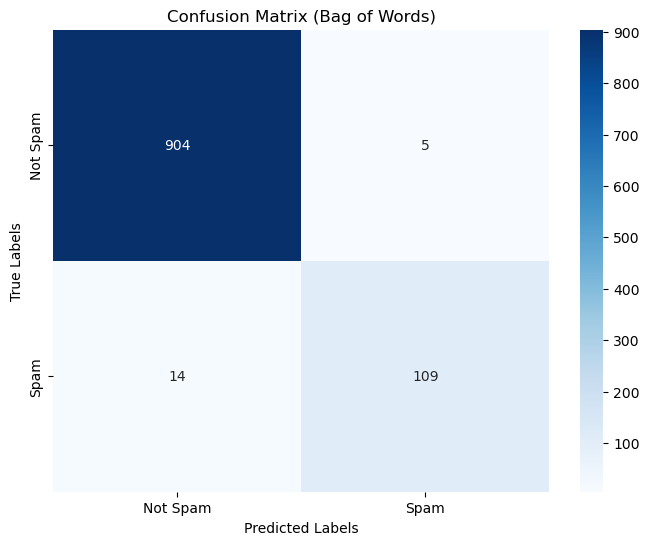

In [15]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_bow)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Bag of Words)')
plt.show()

### Case II: Applying SVC to the TF-IDF Features:

In [16]:
# Fit the Model:
grid.fit(X_train_tf, y_train)

# Model Score & Best Parameters:
print('Best Score:', grid.best_score_) 
print('Best C:', grid.best_estimator_.C)
print('Best Class Weights:', grid.best_estimator_.class_weight)

Best Score: 0.8895045236969411
Best C: 1
Best Class Weights: balanced


Cross-validation of GridSearchCV gave the best model F1 value of approximately 0.89 with C = 1 with balanced weights.

In [17]:
# Predict the test data:
X_test_tf = cv.transform(X_test)
y_pred_tf = grid.predict(X_test_tf)

# Model Performance Evaluation:
accuracy = accuracy_score(y_test, y_pred_tf)
print('Precision:', precision_score(y_test, y_pred_tf))
print('Recall:', recall_score(y_test, y_pred_tf))
print('F1-Score:', f1_score(y_test, y_pred_tf))
print(f"Accuracy: {round((accuracy)*100, 2)} %")

Precision: 0.7023809523809523
Recall: 0.959349593495935
F1-Score: 0.8109965635738832
Accuracy: 94.67 %


In [18]:
print('Classification Report (TF-IDF):\n')
print(classification_report(y_test, y_pred_tf, target_names=["Not Spam", "Spam"]))

Classification Report (TF-IDF):

              precision    recall  f1-score   support

    Not Spam       0.99      0.94      0.97       909
        Spam       0.70      0.96      0.81       123

    accuracy                           0.95      1032
   macro avg       0.85      0.95      0.89      1032
weighted avg       0.96      0.95      0.95      1032



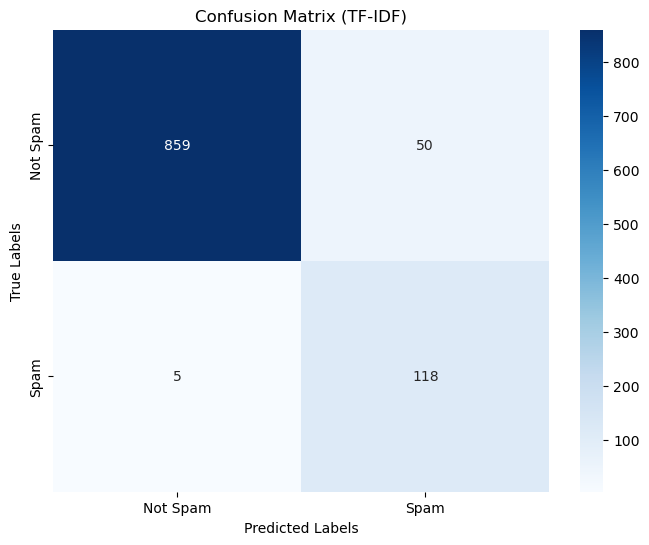

In [19]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_tf)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (TF-IDF)')
plt.show()